In [5]:
try:
    import fairlearn  # noqa: F401
except ModuleNotFoundError:
    %pip -q install fairlearn

try:
    import xgboost  # if you use XGBoost later
except ModuleNotFoundError:
    %pip -q install xgboost

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate
)

import tensorflow as tf
from tensorflow.keras import layers, models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 38.3 MB/s eta 0:00:00


In [6]:
# Upload File
from google.colab import files
uploaded = files.upload()
df=pd.read_csv('diabetic_data.csv')
df.head()

Saving diabetic_data.csv to diabetic_data.csv


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
# DATA CLEANING

# Replace missing '?' markers
df = df.replace('?', np.nan)

# Create binary target (readmitted <30 days)
df['target'] = (df['readmitted'] == '<30').astype(int)

# Drop ID-like columns that add noise / leakage
drop_cols = ['encounter_id', 'patient_nbr', 'readmitted']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Remove invalid genders
df = df[df['gender'] != 'Unknown/Invalid']

df.shape


(101763, 48)

target
0    0.888398
1    0.111602
Name: proportion, dtype: float64


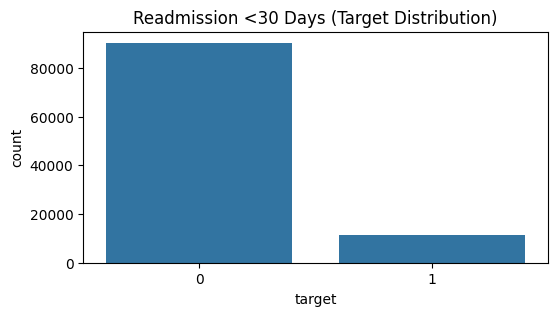

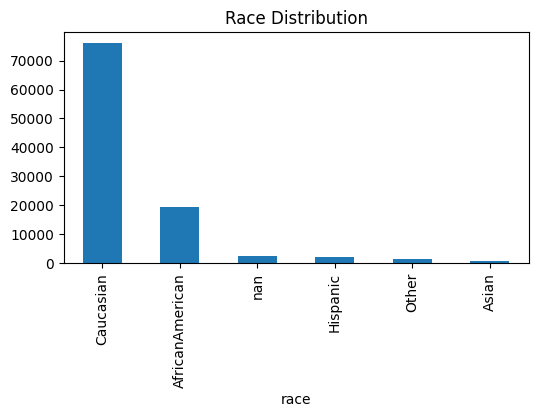

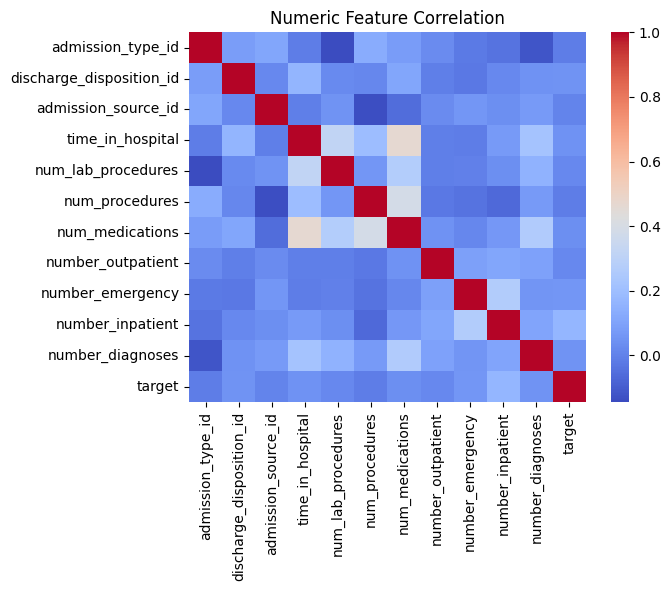

In [8]:
#EXPLORATORY DATA ANALYSIS

print(df['target'].value_counts(normalize=True))

plt.figure(figsize=(6,3))
sns.countplot(x='target', data=df)
plt.title("Readmission <30 Days (Target Distribution)")
plt.show()

# Race distribution
df['race'].value_counts(dropna=False).plot(kind='bar', figsize=(6,3), title='Race Distribution')
plt.show()

# Correlation heatmap (numeric columns only)
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), cmap='coolwarm')
plt.title("Numeric Feature Correlation")
plt.show()


In [19]:
# IDENTIFY FEATURES
strong_features = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses'
]

use = strong_features + ['target']
df_model = df[use].dropna()


In [10]:
# DEFINE DIAG GROUPS

def diag_group(code):
    try:
        code = float(code)
    except:
        return "Other"
    if 390 <= code <= 459 or code == 785:
        return "Circulatory"
    elif 460 <= code <= 519 or code == 786:
        return "Respiratory"
    elif 520 <= code <= 579 or code == 787:
        return "Digestive"
    elif code == 250:
        return "Diabetes"
    elif 800 <= code <= 999:
        return "Injury"
    else:
        return "Other"

for col in ['diag_1','diag_2','diag_3']:
    df_model[col] = df_model[col].apply(diag_group)

In [12]:
# 1) Define which columns to use
categorical = [
    'race', 'gender', 'age',
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'diag_1', 'diag_2', 'diag_3'
]

numeric = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

# 2) Build model dataset (must come BEFORE train-test split)
df_model = df[categorical + numeric + ['target']].dropna()

# 3) Separate features and target
X = df_model.drop(columns=['target'])
y = df_model['target']

# 4) Train-test split (this is the only split — keep this one)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5) Preprocessing (after X is defined)
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('num', StandardScaler(), numeric)
])


In [13]:
# LOGISTIC REGRESSION

lr = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:,1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, lr_probs))
print("F1:", f1_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))


Logistic Regression ROC-AUC: 0.6594599770909257
F1: 0.2761820592134335
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     17398
           1       0.18      0.56      0.28      2213

    accuracy                           0.67     19611
   macro avg       0.55      0.62      0.53     19611
weighted avg       0.84      0.67      0.73     19611



In [14]:
# RANDOM FOREST

rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:,1]

print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("F1:", f1_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest ROC-AUC: 0.6663763726835028
F1: 0.008068130883012102
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17398
           1       0.50      0.00      0.01      2213

    accuracy                           0.89     19611
   macro avg       0.69      0.50      0.47     19611
weighted avg       0.84      0.89      0.83     19611



In [15]:
# NEURAL NETWORK

# Convert processed data to arrays
X_train_nn = preprocess.fit_transform(X_train)
X_test_nn = preprocess.transform(X_test)

input_dim = X_train_nn.shape[1]

# Define the neural network model
nn = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

neg, pos = np.bincount(y_train)
class_weight = {0: 1, 1: neg/pos}

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

history = nn.fit(
    X_train_nn, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight,
    verbose=1
)

nn_probs = nn.predict(X_test_nn).ravel()
nn_pred = (nn_probs >= 0.5).astype(int)

print("Neural Net ROC-AUC:", roc_auc_score(y_test, nn_probs))
print("F1:", f1_score(y_test, nn_pred))
print(classification_report(y_test, nn_pred))

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - AUC: 0.6264 - loss: 1.1806 - val_AUC: 0.6836 - val_loss: 0.6617
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - AUC: 0.6978 - loss: 1.1237 - val_AUC: 0.6783 - val_loss: 0.6462
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - AUC: 0.7285 - loss: 1.0800 - val_AUC: 0.6746 - val_loss: 0.6175
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - AUC: 0.7594 - loss: 1.0279 - val_AUC: 0.6658 - val_loss: 0.5791
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - AUC: 0.7918 - loss: 0.9733 - val_AUC: 0.6527 - val_loss: 0.6415
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - AUC: 0.8219 - loss: 0.9056 - val_AUC: 0.6343 - val_loss: 0.6135
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - AUC: 0.8464 - loss: 0.8483 - val_AUC: 0.6354 - val_loss: 0.5770
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - AUC: 0.8721 - loss: 0.7873 - val_AUC: 0.6264 - val_loss: 0.5880
Epoch 9/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [16]:
# XG BOOST

# Install XGBoost if not already available
!pip install xgboost --quiet

from xgboost import XGBClassifier

# Calculate class imbalance ratio
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight = pos_weight,   # <-- this is the key line
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost Performance ===")
print("ROC-AUC:", roc_auc_score(y_test, xgb_probs))
print("F1 Score:", f1_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))


=== XGBoost Performance ===
ROC-AUC: 0.6644842390898664
F1 Score: 0.2747737294035739
              precision    recall  f1-score   support

           0       0.92      0.70      0.80     17398
           1       0.18      0.54      0.27      2213

    accuracy                           0.68     19611
   macro avg       0.55      0.62      0.54     19611
weighted avg       0.84      0.68      0.74     19611



In [17]:
# IDENTIFY FAIRNESS AND BIAS

race_test = X_test['race']

def fairness_report(model_name, y_true, y_pred, group):
    print(f"\n=== Fairness Metrics: {model_name} by Race ===")
    mf = MetricFrame(
        metrics={
            "selection_rate": selection_rate,
            "TPR": true_positive_rate,
            "FPR": false_positive_rate
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=group
    )
    print(mf.by_group)
    print("\nTPR disparity:", mf.by_group["TPR"].max() - mf.by_group["TPR"].min())
    print("FPR disparity:", mf.by_group["FPR"].max() - mf.by_group["FPR"].min())

fairness_report("Logistic Regression", y_test, lr_pred, race_test)
fairness_report("Random Forest", y_test, rf_pred, race_test)
fairness_report("Neural Network", y_test, nn_pred, race_test)
fairness_report("XGBoost", y_test, xgb_pred, race_test)


=== Fairness Metrics: Logistic Regression by Race ===
                 selection_rate       TPR       FPR
race                                               
AfricanAmerican        0.352542  0.562780  0.324875
Asian                  0.350000  0.571429  0.336283
Caucasian              0.352544  0.566924  0.325399
Hispanic               0.269327  0.553191  0.231638
Other                  0.214765  0.500000  0.180451

TPR disparity: 0.0714285714285714
FPR disparity: 0.15583205802115913

=== Fairness Metrics: Random Forest by Race ===
                 selection_rate       TPR       FPR
race                                               
AfricanAmerican        0.000261  0.002242  0.000000
Asian                  0.000000  0.000000  0.000000
Caucasian              0.001137  0.004759  0.000678
Hispanic               0.000000  0.000000  0.000000
Other                  0.000000  0.000000  0.000000

TPR disparity: 0.004759071980963712
FPR disparity: 0.0006779150346489907

=== Fairness Metrics: N